In [ ]:
#Define functions

import pandas as pd
import numpy as np
from os import listdir
from os.path import getmtime

def read_binaries(binData='Data.bin',binX='X.bin',binY='Y.bin',metaData='Meta.dat'):
    params = {'text':'text pending'}
    with open(binData,'rb') as file:
        hdata = np.fromfile(file, dtype=np.float32)
    with open(binX,'rb') as file:
        xdata = np.fromfile(file, dtype=np.float32)
    with open(binY,'rb') as file:
        ydata = np.fromfile(file, dtype=np.float32)
    iterations = int(len(hdata)/(len(xdata)*len(ydata)))
    Nx = int(len(xdata))
    Ny = int(len(ydata))
    hdata = hdata.reshape((iterations,Ny,Nx))
    return  xdata, ydata, hdata, params
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

#Import only the parameters from the file
def read_params(filename = None):
    #If no filename is given, read the last .dat file
    if filename == None:
        #Animate a file
        last_date = 0
        dat_files = listdir()
        for f in dat_files:
            if f.endswith('.dat'):
                date = getmtime(f)
                if date > last_date:
                    last_date = date
                    filename = f

    #Open file and read the first lines
    data = open(filename)
    text = ''
    params = {}

    params1 = ['Type']
    for i in range(len(params1)):
        row   = data.readline()
        text += row
        params.update({params1[i]:row.split(':')[1][1:-1]})
    params2 = ['Time','deltaX','deltaY','deltaT']
    for i in range(len(params2)):
        row   = data.readline()
        text += row
        value = float(row.split(':')[1])
        params.update({params2[i]:value})
    params3 = ['Nx','Ny','iterations','saved','nBlocks','nThreads']
    for i in range(len(params3)):
        row   = data.readline()
        text += row
        params.update({params3[i]:int(row.split(':')[1])})
    params.update({'text':text})

    return params

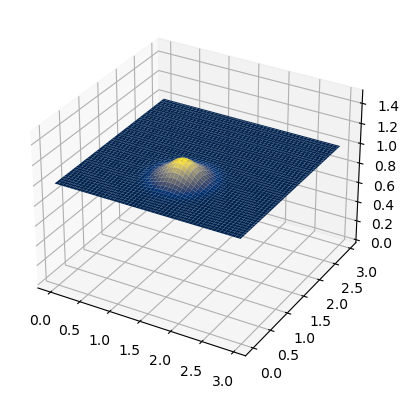

In [4]:
#animate_data('File.dat')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation

x,y,f,params = read_binaries()
Nx = int(len(x))
Ny = int(len(y))

IPF = 1 #Iterations per frame

def update_plot(frame_number, zarray, plot):
    frame = frame_number*IPF
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Y, Zarray[frame],color='0.75',cmap='cividis')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)
Zarray = f

plot = [ax.plot_surface(X, Y, Zarray[0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,1.5)
animate = animation.FuncAnimation(fig, update_plot, int(len(f)/IPF), fargs=(Zarray, plot))
animate.save('shallow_waters.gif',writer='pillow')

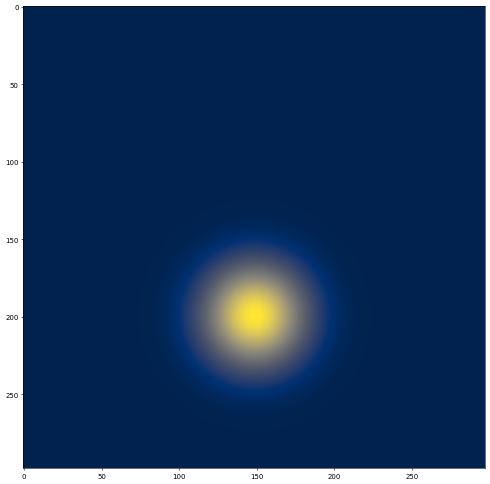

In [14]:
#animate_heatmap('File.dat')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

x,y,f,params = read_binaries()
Nx = int(len(x))
Ny = int(len(y))

IPF = 1 #Iterations per frame

def update_plot(frame_number, zarray, plot):
    frame = frame_number*IPF
    plot.set_data(Zarray[frame])

fig, ax = plt.subplots(1,1,figsize=(12,12),dpi=50)

Zarray = f


plot = ax.imshow(Zarray[0], cmap='cividis')
animate = animation.FuncAnimation(fig, update_plot, int(len(f)/IPF), fargs=(Zarray, plot))
animate.save('shallow_waters.gif',writer='pillow')

(0.0, 1.5)

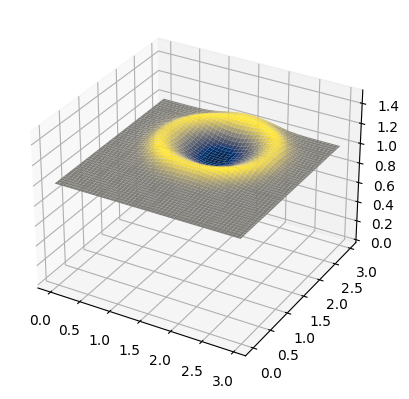

In [11]:
#Plot single image

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation

x,y,f,params = read_binaries()
Nx = int(len(x))
Ny = int(len(y))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)
Zarray = f

plot = [ax.plot_surface(X, Y, Zarray[0], color='0.75', cmap='cividis')]
ax.set_zlim(0,1.5)

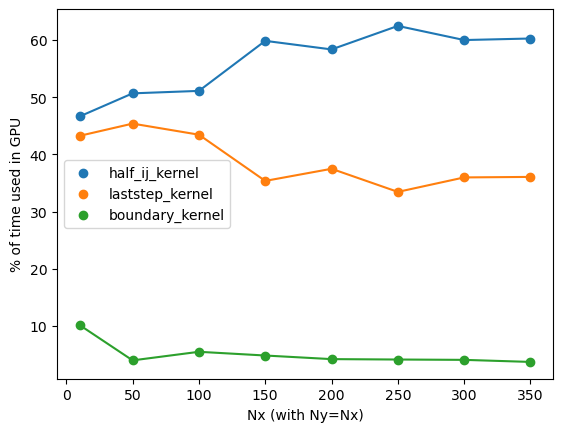

In [18]:
import matplotlib.pyplot as plt

ij_kernel       = [46.62,50.66,51.09,59.84,58.34,62.45,59.98,60.25]
last_kernel     = [43.23,45.37,43.43,35.35,37.47,33.43,35.96,36.05]
boundary_kernel = [10.15, 3.97, 5.47, 4.82, 4.19, 4.12, 4.06, 3.70]
#NxNy = [10*10, 50*50, 100*100, 150*150, 200*200,250*250, 300*300, 350*350]
NxNy = [10, 50, 100, 150, 200,250, 300, 350]

plt.scatter(NxNy,ij_kernel,label='half_ij_kernel')
plt.plot(NxNy,ij_kernel)
plt.scatter(NxNy,last_kernel,label='laststep_kernel')
plt.plot(NxNy,last_kernel)
plt.scatter(NxNy,boundary_kernel,label='boundary_kernel')
plt.plot(NxNy,boundary_kernel)

plt.ylabel('% of time used in GPU')
plt.xlabel('Nx (with Ny=Nx)')
plt.legend()
plt.show()

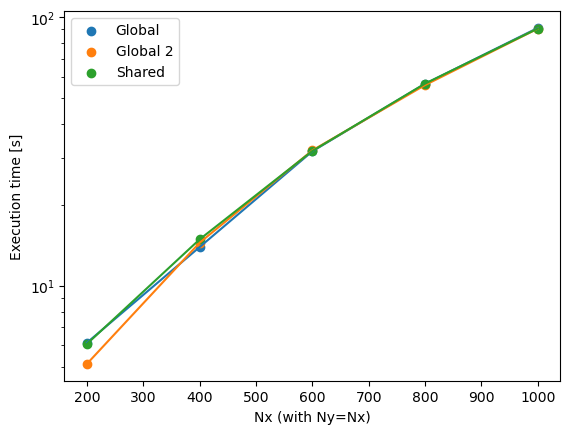

In [ ]:
#read all data
from os import listdir

times_global = []
times_global2 = []
times_shared = []
sizes_global = []
sizes_global2 = []
sizes_shared = []
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Meta') and f.endswith('.dat'))]
for file in folder_files:
        metadata = read_params(file)
        if metadata['Type']=='Cuda global memory':
            times_global.append(metadata['Time'])
            sizes_global.append(metadata['Nx'])
        if metadata['Type']=='Cuda global memory 2':
            times_global2.append(metadata['Time'])
            sizes_global2.append(metadata['Nx'])
        if metadata['Type']=='Cuda shared memory':
            times_shared.append(metadata['Time'])
            sizes_shared.append(metadata['Nx'])

plt.scatter(sizes_global,times_global,label='Global')
plt.plot(sizes_global,times_global)
plt.scatter(sizes_global2,times_global2, label='Global 2')
plt.plot(sizes_global2,times_global2)
plt.scatter(sizes_shared,times_shared,label='Shared')
plt.plot(sizes_shared,times_shared)

plt.yscale('log')
plt.legend()

plt.ylabel('Execution time [s]')
plt.xlabel('Nx (with Ny=Nx)')


plt.show()

In [22]:
times_global

[]